In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
import tqdm
import sys
import os
import gc
import argparse
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pickle
#计算shap值
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']
import math

In [2]:
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('expand_frame_repr', False)  # 即“禁止换行”
# pd.set_option('display.precision', 2) #展示两位小数点
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df_data_交易=pd.read_csv('data/账户交易信息.csv')
df_data_交易.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
df_data_账户=pd.read_csv('data/账户静态信息.csv')
df_data_账户.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
df_label_train=pd.read_csv('data/训练集标签.csv')
df_label_train.columns = ['账户代号','label']
df_label_test=pd.read_csv('data/test_dataset.csv')
df_label_test.columns = ['账户代号']## 读取数据
df_label_all=pd.concat([df_label_train,df_label_test])

### 特征提取

#### 抹账处理

In [4]:
df_mid = df_label_all.copy() ;

In [5]:
list_mz_index = [] ;
# 抹账数据处理
df_data_抹账=df_data_交易[df_data_交易['账户代号'].isin(df_data_交易[df_data_交易['交易金额']<0]['账户代号'].unique())].sort_values(by=['账户代号','交易日期','交易时间'],ascending=True)
df_data_抹账.index=range(len(df_data_抹账))
#待剔除数据
tc_idx=set()
for idx in df_data_抹账[df_data_抹账['交易金额']<0].index:
    for d in range(1,5):
        #print(idx)
        if -df_data_抹账.loc[idx,'交易金额']==df_data_抹账.loc[idx-d,'交易金额'] and df_data_抹账.loc[idx,'账户代号']==df_data_抹账.loc[idx-d,'账户代号']\
            and df_data_抹账.loc[idx,'对方账号']==df_data_抹账.loc[idx-d,'对方账号']:
                list_mz_index.append(idx-d) ;
                tc_idx.add(idx)
                tc_idx.add(idx-d)
                break
tc_idx=list(tc_idx)
df_data_交易_去除抹账后=df_data_抹账[~df_data_抹账.index.isin(tc_idx)]
df_data_交易_去除抹账后=pd.concat([df_data_交易_去除抹账后,df_data_交易[df_data_交易['交易金额']>=0]])

In [6]:
# 取出抹账的数据
df_mz = df_data_抹账.loc[list_mz_index , ['账户代号' , '交易金额']] ;
df_mz_agg = df_mz.groupby('账户代号')['交易金额'].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_mz_agg.columns = ['账户代号'] + ['抹账_'+ f for f in df_mz_agg.columns.values if f not in ['账户代号']]

In [7]:
df_mid=df_mid.merge(df_mz_agg,on='账户代号',how='left') ;

#### 交易渠道

In [8]:
# 获取所有交易渠道
df_data_交易_去除抹账后["交易渠道"].unique()
# 每个客户针对每个交易渠道，去取有多少;
for i in df_data_交易_去除抹账后["交易渠道"].unique() :
    df_now = df_data_交易_去除抹账后[(df_data_交易_去除抹账后["交易渠道"] == i)].groupby("账户代号")["交易金额","交易余额"].agg(["count",'sum','mean','max','min','std']).reset_index() ;
    df_now.columns = ["账户代号"] + ["渠道代号_" + i + "_" + "_".join(f) for f in df_now.columns if f[0] != "账户代号"]
    df_mid = df_mid.merge(df_now , how="left") ;

In [9]:
df_mid.head(100)

,账户代号,label,抹账_sum,抹账_count,抹账_mean,抹账_max,抹账_min,抹账_std,抹账_ptp,渠道代号_E96ED478_交易金额_count,渠道代号_E96ED478_交易金额_sum,渠道代号_E96ED478_交易金额_mean,渠道代号_E96ED478_交易金额_max,渠道代号_E96ED478_交易金额_min,渠道代号_E96ED478_交易金额_std,渠道代号_E96ED478_交易余额_count,渠道代号_E96ED478_交易余额_sum,渠道代号_E96ED478_交易余额_mean,渠道代号_E96ED478_交易余额_max,渠道代号_E96ED478_交易余额_min,渠道代号_E96ED478_交易余额_std,渠道代号_091D584F_交易金额_count,渠道代号_091D584F_交易金额_sum,渠道代号_091D584F_交易金额_mean,渠道代号_091D584F_交易金额_max,渠道代号_091D584F_交易金额_min,渠道代号_091D584F_交易金额_std,渠道代号_091D584F_交易余额_count,渠道代号_091D584F_交易余额_sum,渠道代号_091D584F_交易余额_mean,渠道代号_091D584F_交易余额_max,渠道代号_091D584F_交易余额_min,渠道代号_091D584F_交易余额_std,渠道代号_757B505C_交易金额_count,渠道代号_757B505C_交易金额_sum,渠道代号_757B505C_交易金额_mean,渠道代号_757B505C_交易金额_max,渠道代号_757B505C_交易金额_min,渠道代号_757B505C_交易金额_std,渠道代号_757B505C_交易余额_count,渠道代号_757B505C_交易余额_sum,渠道代号_757B505C_交易余额_mean,渠道代号_757B505C_交易余额_max,渠道代号_757B505C_交易余额_min,渠道代号_757B505C_交易余额_std,渠道代号_892C91E0_交易金额_count,渠道代号_892C91E0_交易金额_sum,渠道代号_892C91E0_交易金额_mean,渠道代号_892C91E0_交易金额_max,渠道代号_892C91E0_交易金额_min,渠道代号_892C91E0_交易金额_std,渠道代号_892C91E0_交易余额_count,渠道代号_892C91E0_交易余额_sum,渠道代号_892C91E0_交易余额_mean,渠道代号_892C91E0_交易余额_max,渠道代号_892C91E0_交易余额_min,渠道代号_892C91E0_交易余额_std,渠道代号_F47D0AD3_交易金额_count,渠道代号_F47D0AD3_交易金额_sum,渠道代号_F47D0AD3_交易金额_mean,渠道代号_F47D0AD3_交易金额_max,渠道代号_F47D0AD3_交易金额_min,渠道代号_F47D0AD3_交易金额_std,渠道代号_F47D0AD3_交易余额_count,渠道代号_F47D0AD3_交易余额_sum,渠道代号_F47D0AD3_交易余额_mean,渠道代号_F47D0AD3_交易余额_max,渠道代号_F47D0AD3_交易余额_min,渠道代号_F47D0AD3_交易余额_std,渠道代号_621461AF_交易金额_count,渠道代号_621461AF_交易金额_sum,渠道代号_621461AF_交易金额_mean,渠道代号_621461AF_交易金额_max,渠道代号_621461AF_交易金额_min,渠道代号_621461AF_交易金额_std,渠道代号_621461AF_交易余额_count,渠道代号_621461AF_交易余额_sum,渠道代号_621461AF_交易余额_mean,渠道代号_621461AF_交易余额_max,渠道代号_621461AF_交易余额_min,渠道代号_621461AF_交易余额_std,渠道代号_B706835D_交易金额_count,渠道代号_B706835D_交易金额_sum,渠道代号_B706835D_交易金额_mean,渠道代号_B706835D_交易金额_max,渠道代号_B706835D_交易金额_min,渠道代号_B706835D_交易金额_std,渠道代号_B706835D_交易余额_count,渠道代号_B706835D_交易余额_sum,渠道代号_B706835D_交易余额_mean,渠道代号_B706835D_交易余额_max,渠道代号_B706835D_交易余额_min,渠道代号_B706835D_交易余额_std,渠道代号_274AD478_交易金额_count,渠道代号_274AD478_交易金额_sum,渠道代号_274AD478_交易金额_mean,渠道代号_274AD478_交易金额_max,渠道代号_274AD478_交易金额_min,渠道代号_274AD478_交易金额_std,渠道代号_274AD478_交易余额_count,渠道代号_274AD478_交易余额_sum,渠道代号_274AD478_交易余额_mean,渠道代号_274AD478_交易余额_max,渠道代号_274AD478_交易余额_min,渠道代号_274AD478_交易余额_std,渠道代号_B6A1085A_交易金额_count,渠道代号_B6A1085A_交易金额_sum,渠道代号_B6A1085A_交易金额_mean,渠道代号_B6A1085A_交易金额_max,渠道代号_B6A1085A_交易金额_min,渠道代号_B6A1085A_交易金额_std,渠道代号_B6A1085A_交易余额_count,渠道代号_B6A1085A_交易余额_sum,渠道代号_B6A1085A_交易余额_mean,渠道代号_B6A1085A_交易余额_max,渠道代号_B6A1085A_交易余额_min,渠道代号_B6A1085A_交易余额_std,渠道代号_854D6FAE_交易金额_count,渠道代号_854D6FAE_交易金额_sum,渠道代号_854D6FAE_交易金额_mean,渠道代号_854D6FAE_交易金额_max,渠道代号_854D6FAE_交易金额_min,渠道代号_854D6FAE_交易金额_std,渠道代号_854D6FAE_交易余额_count,渠道代号_854D6FAE_交易余额_sum,渠道代号_854D6FAE_交易余额_mean,渠道代号_854D6FAE_交易余额_max,渠道代号_854D6FAE_交易余额_min,渠道代号_854D6FAE_交易余额_std,渠道代号_6974CE5A_交易金额_count,渠道代号_6974CE5A_交易金额_sum,渠道代号_6974CE5A_交易金额_mean,渠道代号_6974CE5A_交易金额_max,渠道代号_6974CE5A_交易金额_min,渠道代号_6974CE5A_交易金额_std,渠道代号_6974CE5A_交易余额_count,渠道代号_6974CE5A_交易余额_sum,渠道代号_6974CE5A_交易余额_mean,渠道代号_6974CE5A_交易余额_max,渠道代号_6974CE5A_交易余额_min,渠道代号_6974CE5A_交易余额_std,渠道代号_38B3EFF8_交易金额_count,渠道代号_38B3EFF8_交易金额_sum,渠道代号_38B3EFF8_交易金额_mean,渠道代号_38B3EFF8_交易金额_max,渠道代号_38B3EFF8_交易金额_min,渠道代号_38B3EFF8_交易金额_std,渠道代号_38B3EFF8_交易余额_count,渠道代号_38B3EFF8_交易余额_sum,渠道代号_38B3EFF8_交易余额_mean,渠道代号_38B3EFF8_交易余额_max,渠道代号_38B3EFF8_交易余额_min,渠道代号_38B3EFF8_交易余额_std,渠道代号_7EABE3A1_交易金额_count,渠道代号_7EABE3A1_交易金额_sum,渠道代号_7EABE3A1_交易金额_mean,渠道代号_7EABE3A1_交易金额_max,渠道代号_7EABE3A1_交易金额_min,渠道代号_7EABE3A1_交易金额_std,渠道代号_7EABE3A1_交易余额_count,渠道代号_7EABE3A1_交易余额_sum,渠道代号_7EABE3A1_交易余额_mean,渠道代号_7EABE3A1_交易余额_max,渠道代号_7EABE3A1_交易余额_min,渠道代号_7EABE3A1_交易余额_std,渠道代号_F57A2F55_交易金额_count,渠道代号_F57A2F55_交易金额_sum,渠道代号_F57A2F55_交易金额_mean,渠道代号_F57A2F55_交易金额_max,渠道代号_F57A2F55_交易金额_min,渠道代号_F57A2F55_交易金额_std,渠道代号_F57A2F55_交易余额_count,渠道代号_F57A2F55_交易余额_sum,渠道代号_F57A2F55_交易余额_mean,渠道代号_F57A2F55_交易余额_max,渠道代号_F57A2F55_交易余额_min,渠道代号_F57A2F

### 特征筛选、训练

In [45]:
df_all = df_mid

In [46]:
train_label = df_all[:len(df_label_train)] ;
test_label = df_all[len(df_label_train):] ;

In [47]:
def corr_filter(train_data,corr_threshold):
    corr_data=train_data.corr()
    corr_data=corr_data.where(np.triu(np.ones(corr_data.shape),k=1).astype(np.bool))
    high_corr=[column for column in corr_data.columns if any(corr_data[column].abs()>corr_threshold)]
    result=[c for c in train_data.columns if c not in high_corr]
    print("筛选后特征:",len(result))
    return result

In [48]:
cols = [f for f in train_label.columns if f not in ['账户代号','label']]

In [53]:
cols

['渠道代号_6F3EF77A_交易余额_sum',
 '渠道代号_EAE27D77_交易余额_sum',
 '渠道代号_979D472A_交易金额_sum',
 '渠道代号_EAE27D77_交易余额_max',
 '渠道代号_EAE27D77_交易余额_min',
 '渠道代号_EAE27D77_交易余额_std',
 '渠道代号_979D472A_交易金额_count',
 '渠道代号_979D472A_交易金额_mean',
 '渠道代号_979D472A_交易金额_max',
 '渠道代号_979D472A_交易金额_min',
 '渠道代号_979D472A_交易金额_std',
 '渠道代号_979D472A_交易余额_count',
 '渠道代号_979D472A_交易余额_sum',
 '渠道代号_979D472A_交易余额_mean',
 '渠道代号_979D472A_交易余额_max',
 '渠道代号_979D472A_交易余额_min',
 '渠道代号_6F3EF77A_交易金额_std',
 '渠道代号_6F3EF77A_交易余额_count',
 '渠道代号_6974CE5A_交易余额_std',
 '渠道代号_6F3EF77A_交易金额_min',
 '渠道代号_E205EE2A_交易金额_count',
 '渠道代号_6974CE5A_交易金额_std',
 '渠道代号_AA169B49_交易金额_count',
 '渠道代号_AA169B49_交易金额_sum',
 '渠道代号_AA169B49_交易金额_mean',
 '渠道代号_AA169B49_交易金额_max',
 '渠道代号_AA169B49_交易金额_min',
 '渠道代号_AA169B49_交易金额_std',
 '渠道代号_AA169B49_交易余额_count',
 '渠道代号_AA169B49_交易余额_sum',
 '渠道代号_AA169B49_交易余额_mean',
 '渠道代号_AA169B49_交易余额_max',
 '渠道代号_AA169B49_交易余额_min',
 '渠道代号_AA169B49_交易余额_std',
 '渠道代号_E205EE2A_交易金额_sum',
 '渠道代号_6F3EF77A_交易金额_max',
 '渠道代号_E205E

In [50]:
cols =corr_filter(train_label[cols],0.95)

筛选后特征: 124


In [38]:
def 对抗验证获取数据(df_train,df_test,threshold):
    # 定义新的Y
    
    
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1
    #print(df_train.columns)
    #print(df_test.columns)
    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])
    #print(df_adv.columns)
    #catecol_list_index=[list(df_train.columns).index(c) for c in df_train.select_dtypes(include=['category']).columns]
    # 通过抗验证中的模型，得到各个样本属于测试集的概率


    
    model_adv =  lgb.LGBMClassifier()
    model_adv.fit(df_adv.drop(['label','Is_Test'], axis=1), df_adv.loc[:, 'Is_Test'])
    preds_adv = model_adv.predict_proba(df_adv.drop(['label','Is_Test'], axis=1))[:, 1]
    
    df_train_copy = df_train.copy()
    df_train_copy['is_test_prob'] = preds_adv[:len(df_train)]

    # 根据概率排序
    df_train_copy = df_train_copy.sort_values('is_test_prob').reset_index(drop=True)

    # 将概率最大的20%作为验证集
    df_validation_2 = df_train_copy.iloc[int(threshold * len(df_train)):, ]
    df_train_2 = df_train_copy.iloc[:int(threshold * len(df_train)), ]
    return df_validation_2.drop(['is_test_prob','Is_Test'], axis=1)#,df_train_copy.drop(['Is_Test'],axis=1)
def 对抗验证获得新的列(df_train,df_test,threshold):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])

    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':32,'max_depth':10,'n_estimators':200,'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.08}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])
    #preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})

    im=im.sort_values(by='importance',ascending=False)
        
    new_cat=im.reset_index().loc[round(len(im)*threshold):,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return new_cat

In [52]:
new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.6)
cols=list(new_cat)
col_valid=cols.copy()
col_valid.append('label')
valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.8)

对抗验证后的特征数量为: 50


In [20]:
# new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0)
# cols=list(new_cat)
# col_valid=cols.copy()
# col_valid.append('label')
# valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0)

对抗验证后的特征数量为: 127


In [40]:
cols

['渠道代号_6F3EF77A_交易余额_sum',
 '渠道代号_EAE27D77_交易余额_sum',
 '渠道代号_979D472A_交易金额_sum',
 '渠道代号_EAE27D77_交易余额_max',
 '渠道代号_EAE27D77_交易余额_min',
 '渠道代号_EAE27D77_交易余额_std',
 '渠道代号_979D472A_交易金额_count',
 '渠道代号_979D472A_交易金额_mean',
 '渠道代号_979D472A_交易金额_max',
 '渠道代号_979D472A_交易金额_min',
 '渠道代号_979D472A_交易金额_std',
 '渠道代号_979D472A_交易余额_count',
 '渠道代号_979D472A_交易余额_sum',
 '渠道代号_979D472A_交易余额_mean',
 '渠道代号_979D472A_交易余额_max',
 '渠道代号_979D472A_交易余额_min',
 '渠道代号_6F3EF77A_交易金额_std',
 '渠道代号_6F3EF77A_交易余额_count',
 '渠道代号_6974CE5A_交易余额_std',
 '渠道代号_6F3EF77A_交易金额_min',
 '渠道代号_E205EE2A_交易金额_count',
 '渠道代号_6974CE5A_交易金额_std',
 '渠道代号_AA169B49_交易金额_count',
 '渠道代号_AA169B49_交易金额_sum',
 '渠道代号_AA169B49_交易金额_mean',
 '渠道代号_AA169B49_交易金额_max',
 '渠道代号_AA169B49_交易金额_min',
 '渠道代号_AA169B49_交易金额_std',
 '渠道代号_AA169B49_交易余额_count',
 '渠道代号_AA169B49_交易余额_sum',
 '渠道代号_AA169B49_交易余额_mean',
 '渠道代号_AA169B49_交易余额_max',
 '渠道代号_AA169B49_交易余额_min',
 '渠道代号_AA169B49_交易余额_std',
 '渠道代号_E205EE2A_交易金额_sum',
 '渠道代号_6F3EF77A_交易金额_max',
 '渠道代号_E205E

In [41]:
def cv_model(clf, train_x, train_y, test_x, clf_name,valid_x):
    folds = 5
    seed = 2023
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])
    predict_valid = np.zeros(valid_x.shape[0])
    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }

            model = clf.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 8
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
            
            valid_dk_matrix = clf.DMatrix(valid_x)
            valid_pred= model.predict(valid_dk_matrix, ntree_limit=model.best_ntree_limit)
        if clf_name == "cat":
            model = clf(
                        n_estimators=10000,
                        random_seed=2023,
                        eval_metric='AUC',
                        learning_rate=0.05,
                        max_depth=7,
                        early_stopping_rounds=200,
                        metric_period=500,
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            valid_pred= model.predict_proba(valid_x)[:,1]
            
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        predict_valid +=valid_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
       
    return oof, predict,predict_valid,model

In [42]:
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid[cols])
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb',valid[cols])


************************************ 1 ************************************
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.59ms	remaining: 25.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.
[0.5]
************************************ 2 ************************************
0:	test: 0.5000000	best: 0.5000000 (0)	total: 1.8ms	remaining: 18.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.
[0.5, 0.5]
************************************ 3 ************************************
0:	test: 0.5000000	best: 0.5000000 (0)	total: 1.62ms	remaining: 16.2s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.
[0.5, 0.5, 0.5]
************************************ 4 ************************************
0:	test: 0.5000000	best: 0.5000000 (0)	total: 1.6ms	remaining: 16s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.
[0.5, 0.5, 0.5, 0.5]
************************************ 5 ************************************
0:	test: 0.5000000	best: 0.5000000 (0)	total: 1.63ms	remaining: 16.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5
bestIteration = 0

Shrink model to first 1 iterations.
[0.5, 0.5, 0.5, 0.5, 0.5]


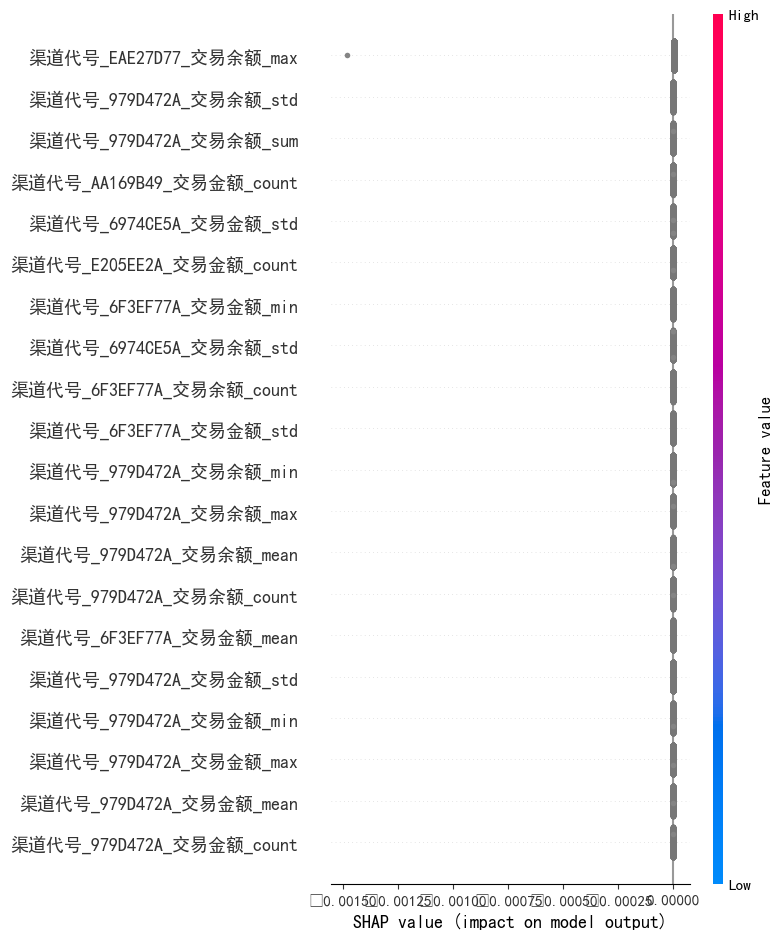

In [43]:
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(train_label[cols])
#shap.summary_plot(shap_values[1], train_label[cols])
shap.summary_plot(shap_values, train_label[cols])

In [44]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>0.42).astype('int')
result=test_label[['账户代号','label']]
result.columns=['zhdh','black_flag']
result.to_csv('submission20230305.csv', index=False)
result['black_flag'].value_counts()

1    4800
Name: black_flag, dtype: int64